# Policy-based Agent using PyTorch

In [1]:
import time
import torch
import imageio
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

## Environment

|        | TYPE             | VALUES | DESCRIPTION                                                                     |
|--------|------------------|--------|---------------------------------------------------------------------------------|
| Action | ndarray<br/>(1,) | {0, 1} | Direction to push cart.<br/>0: left<br/>1: right                                |
| Observation | ndarray<br/>(4,) | float  | 1. Cart position<br/>2. Cart velocity<br/>3. Pole angle<br/>4. Angular velocity |
| Reward |  | float | Reward is given for every step taken, including the termination step.<br/>Each step provides a reward of +1 |
| Termination &<br/>Truncation |  | boolean | Pole Angle exceeds ± 0.2095 rad<br/>Cart Position exceeds ± 2.4 (i.e., edge of the display)<br/>Episode length is greater than 500 |

In [2]:
environment = gym.make('CartPole-v1', render_mode="rgb_array")

## Agent

In [3]:
class Agent(torch.nn.Module):
    def __init__(self, optimizer, lr=0.00025, discount=0.99):
        """
        Simple Agent for reinforcement learning with one hidden layer.
        
        Parameters
        ----------
        optimizer : torch.optim.X
            Optimizer for the Agent to learn.
        lr : float, optional
            Learning rate for the optimizer.
        discount : float, optional
            Discount factor for future rewards. 
            --> 0: only consider immediate rewards
            --> 1: consider all future rewards equally
        """
        super(Agent, self).__init__()
        
        # ARCHITECTURE
        # --------------------------------------------------
        
        self.layer_in = torch.nn.Linear(4, 20)
        self.layer_hidden = torch.nn.Linear(20, 80)
        self.layer_out = torch.nn.Linear(80, 2)
        
        # LEARNING
        # --------------------------------------------------
        
        self.discount = discount
        self.optimizer = optimizer(self.parameters(), lr=lr)
        
        # MEMORY
        # --------------------------------------------------
        
        self.logarithms = []
        self.rewards = []
        
    def forward(self, state):
        """
        Forward pass with softmax output.
        
        Parameters
        ----------
        state : torch.Tensor
            Observed state.
            
        Returns
        -------
        output : torch.Tensor
            Action probabilities.
        """
        _output = torch.relu(self.layer_in(state))
        _output = torch.relu(self.layer_hidden(_output))
        output = torch.softmax(self.layer_out(_output), dim=-1)
        
        return output
    
    def action(self, state):
        """
        Stochastic action selection.
        
        Parameters
        ----------
        state : torch.Tensor
            Observed state.
            
        Returns
        -------
        action : int
            Selected action.
        logarithm : torch.Tensor
            Logarithm of the selected action probability.
        """
        actions = self(state)
        
        action = np.random.choice([0, 1], 1, p=actions.detach().numpy())[0]
        logarithm = torch.log(actions[action])
        
        return action, logarithm
    
    def learn(self):
        """
        REINFORCE algorithm; a policy-based gradient method, with respect to the last game played.
        
        Returns
        -------
        gradient : float
        
        Notes
        -----
        In order for the Agent to best learn the optimal actions, it is common to evaluate the 
        expected future rewards. Then, the Agent can adjust its predicted action probabilities 
        (policy) so that this expected reward is maximized. This is done through the REINFORCE 
        algorithm, which computes the policy gradient. Algorithm modified from:
            
         https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63
        """
        rewards = torch.tensor(self.rewards, dtype=torch.float32)
        
        # EXPECTED FUTURE REWARDS
        # --------------------------------------------------
        # The expected reward given an action is the sum of all future (discounted) rewards. This is 
        # achieved by reversely adding the observed reward and the discounted cumulative future 
        # rewards. The rewards are then standardized.
        
        _reward = 0
        for i in reversed(range(len(rewards))):
            _reward = _reward * self.discount + rewards[i]
            rewards[i] = _reward
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-9)
        
        # POLICY GRADIENT
        # --------------------------------------------------
        # The policy gradient is the gradient of the expected reward with respect to the action 
        # taken (policy). This is computed by multiplying the logarithm of the selected action 
        # probability (see `action` method) with the standardized expected reward — previously 
        # calculated. The overall gradient is then the sum of all these products.
        
        gradient = torch.zeros_like(rewards)
        for i, (logarithm, reward) in enumerate(zip(self.logarithms, rewards)):
            gradient[i] = -logarithm * reward            
        gradient = gradient.sum()
        
        # BACKPROPAGATION
        # --------------------------------------------------
        # The gradient is then used to update the Agent's policy. This is done by backpropagating
        # with the optimizer using the gradient.
        
        self.optimizer.zero_grad()
        gradient.backward()
        self.optimizer.step()

        self.logarithms, self.rewards = [], []
        
        return gradient.item()
    
    def append(self, logarithm, reward):
        """
        Append observation, action and reward to Agent memory.
        
        Parameters
        ----------
        logarithm : torch.Tensor
            Logarithm of the selected action probability.
        reward : int
            Reward from the chosen action.
        """
        self.logarithms.append(logarithm)
        self.rewards.append(reward)

## Training

In [4]:
GAMES = 10000

LEARNING_RATE = 0.00025
REWARD_DISCOUNT = 0.99

agent = Agent(optimizer=torch.optim.RMSprop, lr=LEARNING_RATE,
              discount=REWARD_DISCOUNT)

checkpoint = GAMES // 10
metrics = {"steps": torch.zeros(GAMES), "gradients": torch.zeros(GAMES)}

In [5]:
start = time.time()
for game in range(1, GAMES + 1):
    
    observation = torch.tensor(environment.reset()[0], dtype=torch.float32)  # noqa
    terminated = truncated = False
    
    # LEARNING FROM GAME
    # --------------------------------------------------
    
    steps = 0
    while not (terminated or truncated):
        steps += 1
        action, logarithm = agent.action(observation)
        observation, reward, terminated, truncated, _ = environment.step(action)
        observation = torch.tensor(observation, dtype=torch.float32)
        agent.append(logarithm, reward)
    gradient = agent.learn()
    
    # METRICS
    # --------------------------------------------------
    
    metrics["steps"][game-1] = steps
    metrics["gradients"][game-1] = gradient
    
    if game % checkpoint == 0 or game == GAMES:

        _mean_steps = metrics["steps"][max(0, game-checkpoint-1):game-1].mean()
        _mean_gradient = metrics["gradients"][max(0, game-checkpoint-1):game-1].mean()
        
        print(f"Game {game:>6} {int(game/GAMES * 100):>16} % \n"
              f"{'-'*30} \n"
              f" > Average steps: {int(_mean_steps):>12} \n"
              f" > Average gradients: {_mean_gradient:>8.4f} \n ")
        
print(f"Total training time: {time.time()-start:.2f} seconds")

Game   1000               10 % 
------------------------------ 
 > Average steps:           65 
 > Average gradients:  -1.2731 
 
Game   2000               20 % 
------------------------------ 
 > Average steps:          230 
 > Average gradients:  -5.5290 
 
Game   3000               30 % 
------------------------------ 
 > Average steps:          378 
 > Average gradients:  -5.7685 
 
Game   4000               40 % 
------------------------------ 
 > Average steps:          442 
 > Average gradients:  -5.4047 
 
Game   5000               50 % 
------------------------------ 
 > Average steps:          475 
 > Average gradients:  -4.9878 
 
Game   6000               60 % 
------------------------------ 
 > Average steps:          483 
 > Average gradients:  -2.6260 
 
Game   7000               70 % 
------------------------------ 
 > Average steps:          492 
 > Average gradients:  -3.6001 
 
Game   8000               80 % 
------------------------------ 
 > Average steps:         

## Visualizing metrics

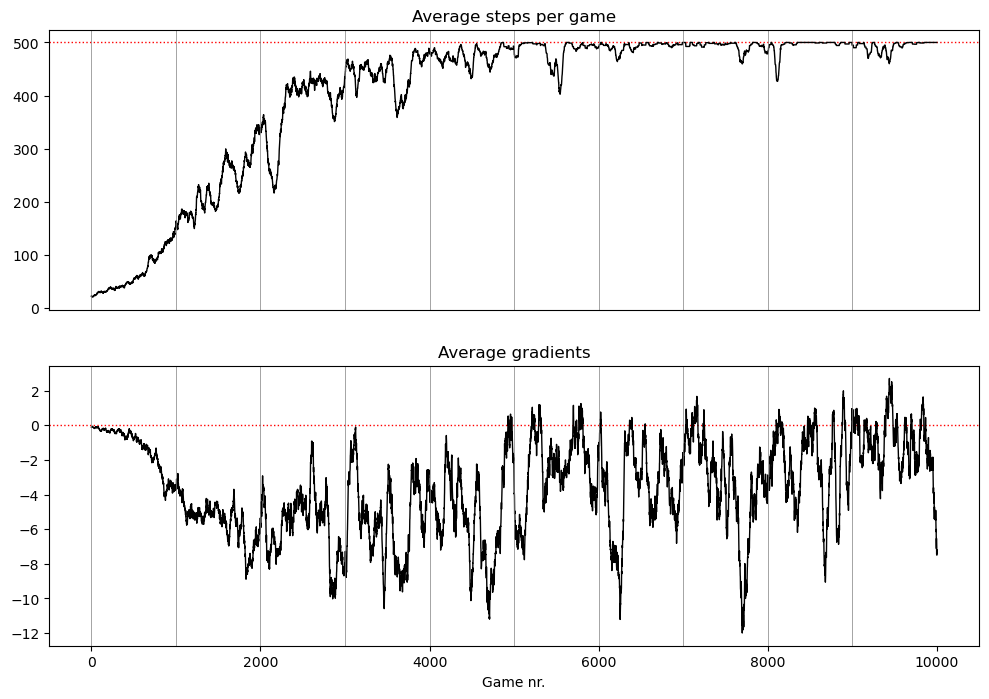

In [6]:
def moving_average(data, window_size=50):
    """Compute moving average with given window size of the data."""
    half_window = window_size // 2
    return [(data[max(0, i-half_window):min(GAMES, i+half_window)]).mean() 
            for i in range(GAMES)]

steps = moving_average(metrics["steps"])
gradients = moving_average(metrics["gradients"])

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].axhline(y=500, color="red", linestyle="dotted", linewidth=1)
ax[0].plot(steps, color="black", linewidth=1)
ax[0].set_xticks([])
ax[0].set_title("Average steps per game")

ax[1].axhline(y=0, color="red", linestyle="dotted", linewidth=1)
ax[1].plot(gradients, color="black", linewidth=1)
ax[1].set_xlabel("Game nr.")
ax[1].set_title("Average gradients")

for i in range(0, GAMES, 1000):
    ax[0].axvline(x=i, color='gray', linewidth=0.5)
    ax[1].axvline(x=i, color='gray', linewidth=0.5)

plt.show()

## Policy-based Agent in action

In [7]:
observation = torch.tensor(environment.reset()[0], dtype=torch.float32)

images = []
terminated = truncated = False
while not (terminated or truncated):
    action, logarithm = agent.action(observation)
    observation, reward, terminated, truncated, _ = environment.step(action)
    observation = torch.tensor(observation, dtype=torch.float32)

    images.append(environment.render())
_ = imageio.mimsave('./policy-based.gif', images, duration=25)

<img src="./policy-based.gif" width="400" height="400" />

In [8]:
environment.close()